<a href="https://colab.research.google.com/github/bijitdeb/Course/blob/master/Building%2Ba%2BCNN%2B_%2BMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Basic CNN: The MNIST Dataset

In this notebook, we will build a simple CNN-based architecture to classify the 10 digits (0-9) of the MNIST dataset. The objective of this notebook is to become familiar with the process of building CNNs in Keras.

We will go through the following steps:
1. Importing libraries and the dataset
2. Data preparation: Train-test split, specifying the shape of the input data etc.
3. Building and understanding the CNN architecture 
4. Fitting and evaluating the model

Let's dive in.

## 1. Importing Libraries and the Dataset

Let's load the required libraries. From Keras, we need to import two main components:
1. `Sequential` from `keras.models`: `Sequential` is the keras abstraction for creating models with a stack of layers (MLP has multiple hidden layers, CNNs have convolutional layers, etc.). 
2. Various types of layers from `keras.layers`: These layers are added (one after the other) to the `Sequential` model.


In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Let's load the MNIST dataset from `keras.datasets`. The download may take a few minutes.

In [ ]:
# load the dataset into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
type(mnist.load_data()[0][0])

numpy.ndarray

In [ ]:
print("train data")
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print("\n test data")
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

train data
x_train: (60000, 28, 28)
y_train: (60000,)

 test data
x_test: (10000, 28, 28)
y_test: (10000,)


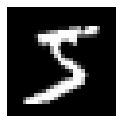

Shape: (28, 28)
Label: 5


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2))
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')
plt.show()
print('Shape:', x_train[0].shape)
print('Label:', y_train[0])

So we have 60,000 training and 10,000 test images each of size 28 x 28. Note that the images are grayscale and thus are stored as 2D arrays.<br> 

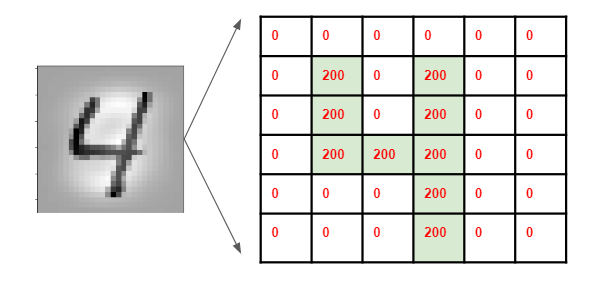

Also, let's sample randomly only 20k images for training (just to speed up the training a bit).

In [ ]:
# sample only 20k images for training
idx = np.random.randint(x_train.shape[0], size=20000) # sample 20k indices from 0-60,000
x_train = x_train[idx, :]
y_train = y_train[idx]
print(x_train.shape)
print(y_train.shape)

(20000, 28, 28)
(20000,)


## 2. Data Preparation

Let's prepare the dataset for feeding to the network. We will do the following three main steps:<br>

#### 2.1 Reshape the Data
First, let's understand the shape in which tensorflow network expects the training data. Tensorflow expects image data to be of `(#pixels in height, #pixels in width, #pixels in depth)` shape. Since MNIST is grayscale image, `#pixels in depth = 1`. Since we have 20,000 training samples each of size (28, 28, 1), the training data (`x_train`) needs to be of the shape `(20000, 28, 28, 1)`. If the images were coloured, the shape would have been `(20000, 28, 28, 3)`, the value 3 representing 3 channels in depth, R (Red), G (Green) and B (Blue), respectively.

Further, each of the 20,000 images have a 0-9 label, so `y_train` needs to be of the shape `(20000, 10)` where each image's label is represented as a 10-d **one-hot encoded vector**.

#### 2.2 Rescaling (Normalisation)
The value of each pixel is between 0-255, so we will **rescale each pixel** by dividing by 255 so that the range becomes 0-1. Recollect <a href="https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn">why normalisation is important for training NNs</a>.

<mark> We are rescaling, but we're not actually normalizing the images. For that we would have to subtract the mean and divide by the standard deviation. </mark> 

#### 2.3 Converting Input Data Type: Int to Float
The pixels are originally stored as type `int`, but it is advisable to feed the data as `float`. This is not really compulsory, but advisable. You can read <a href="https://datascience.stackexchange.com/questions/13636/neural-network-data-type-conversion-float-from-int">why conversion from int to float is helpful here</a>.


In [ ]:
# specify input dimensions of each image
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# batch size, number of classes, epochs
batch_size = 128
num_classes = 10
epochs = 12

Let's now reshape the array `x_train` from shape `(20000, 28, 28)`to `(20000, 28, 28, 1)`. Analogously for `x_test`.

In [ ]:
# reshape x_train and x_test
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
print(x_train.shape)
print(x_test.shape)

(20000, 28, 28, 1)
(10000, 28, 28, 1)


Now let's reshape `y_train` from `(20000,)` to `(20000, 10)`. This can be conveniently done using the keras' `utils` module.

In [ ]:
# convert class labels (from digits) to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)

(20000, 10)


Finally, let's convert the data type of `x_train` and `x_test` from int to float and normalise the images.

In [ ]:
# originally, the pixels are stored as ints
x_train.dtype

dtype('uint8')

In [ ]:
# convert int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalise
x_train /= 255.0
x_test /= 255.0

## 3. Building the Model

Let's now build the CNN architecture. For the MNIST dataset, we do not need to build a very sophisticated CNN - a simple shallow-ish CNN would suffice. 

We will build a network with:
- two convolutional layers having 32 and 64 filters respectively, 
- followed by a max pooling layer, 
- and then `Flatten` the output of the pooling layer to give us a long vector, 
- then add a fully connected `Dense` layer with 128 neurons, and finally
- add a `softmax` layer with 10 neurons since we are doing 10 class multi-class classification.

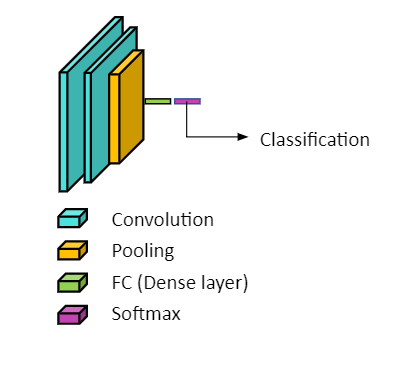

The generic way to build a model in Keras is to instantiate a `Sequential` model and keep adding `keras.layers` to it. We will also use some dropouts.

In [ ]:
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

#### Understanding Model Summary

It is a good practice to spend some time staring at the model summary above and verify the number of parameteres, output sizes etc. Let's do some calculations to verify that we understand the model deeply enough. 

- Layer-1 (Conv2D): We have used 32 kernels of size (3, 3), and each kernel has a single bias, so we have 32 x 3 x 3 (weights) + 32 (biases) = 320 parameters (all trainable). Note that the kernels have only one channel since the input images are 2D (grayscale). By default, a convolutional layer uses stride of 1 and no padding, so the output from this layer is of shape 26 x 26 x 32, as shown in the summary above (the first element `None` is for the batch size).

- Layer-2 (Conv2D): We have used 64 kernels of size (3, 3), but this time, each kernel has to convolve a tensor of size (26, 26, 32) from the previous layer. Thus, the kernels will also have 32 channels, and so the shape of each kernel is (3, 3, 32) (and we have 64 of them). So we have 64 x 3 x 3 x 32 (weights) + 64 (biases) = 18496 parameters (all trainable). The output shape is (24, 24, 64) since each kernel produces a (24, 24) feature map.

- Max pooling: The pooling layer gets the (24, 24, 64) input from the previous conv layer and produces a (12, 12, 64) output (the default pooling uses stride of 2). There are no trainable parameters in the pooling layer.

- The `Dropout` layer does not alter the output shape and has no trainable parameters.

- The `Flatten` layer simply takes in the (12, 12, 64) output from the previous layer and 'flattens' it into a vector of length 12 x 12 x 64 = 9216.

- The `Dense` layer is a plain fully connected layer with 128 neurons. It takes the 9216-dimensional output vector from the previous layer (layer l-1) as the input and has 128 x 9216 (weights) + 128 (biases) =  1179776 trainable parameters. The output of this layer is a 128-dimensional vector.

- The `Dropout` layer simply drops a few neurons.

- Finally, we have a `Dense` softmax layer with 10 neurons which takes the 128-dimensional vector from the previous layer as input. It has 128 x 10 (weights) + 10 (biases) = 1290 trainable parameters.

Thus, the total number of parameters are 1,199,882 all of which are trainable.

## 4. Fitting and Evaluating the Model

Let's now compile and train the model.

In [ ]:
# usual cross entropy loss
# choose any optimiser such as adam, rmsprop etc
# metric is accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
# fit the model
# this should take around 10-15 minutes when run locally on a windows/mac PC 
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
157/157 [==============================] - 14s 13ms/step - loss: 2.2934 - accuracy: 0.1268 - val_loss: 2.2800 - val_accuracy: 0.1916
Epoch 2/12
157/157 [==============================] - 2s 10ms/step - loss: 2.2762 - accuracy: 0.1540 - val_loss: 2.2601 - val_accuracy: 0.2598
Epoch 3/12
157/157 [==============================] - 2s 11ms/step - loss: 2.2568 - accuracy: 0.1991 - val_loss: 2.2395 - val_accuracy: 0.3148
Epoch 4/12
157/157 [==============================] - 2s 11ms/step - loss: 2.2385 - accuracy: 0.2307 - val_loss: 2.2174 - val_accuracy: 0.3590
Epoch 5/12
157/157 [==============================] - 2s 12ms/step - loss: 2.2172 - accuracy: 0.2727 - val_loss: 2.1931 - val_accuracy: 0.4073
Epoch 6/12
157/157 [==============================] - 2s 12ms/step - loss: 2.1931 - accuracy: 0.3063 - val_loss: 2.1660 - val_accuracy: 0.4466
Epoch 7/12
157/157 [==============================] - 2s 11ms/step - loss: 2.1685 - accuracy: 0.3377 - val_loss: 2.1356 - val_accuracy: 0.484

In [ ]:
# evaluate the model on test data
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.9217 - accuracy: 0.6285


[1.9216856956481934, 0.6284999847412109]

In [ ]:
print(model.metrics_names)

['loss', 'accuracy']
